============================================================
### 04 - OPTIMISATION
============================================================


Objectif : Optimiser les hyperparamètres du modèle KNN (meilleur modèle)  
Dataset : df_dropna_normalized.csv  
Méthode : GridSearchCV avec validation croisée stratifiée  


In [26]:
# import
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import os 
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, make_scorer
)

from sklearn.inspection import permutation_importance
from itertools import combinations
from sklearn.inspection import permutation_importance
import pickle


In [12]:
# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

#### Chargement des données

In [13]:
data_path = '../data'
df = pd.read_csv(os.path.join(data_path, 'df_dropna_normalized.csv'))

print(f"   Dataset chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes")

# Séparer X et y
X = df.drop('embauche', axis=1)
y = df['embauche']

print(f"   Features (X) : {X.shape[1]} variables")
print(f"   Target (y) : {y.value_counts().to_dict()}")
print(f"   Ratio classe 1 : {y.mean():.2%}")

   Dataset chargé : 19021 lignes, 39 colonnes
   Features (X) : 38 variables
   Target (y) : {0: 16842, 1: 2179}
   Ratio classe 1 : 11.46%


In [ ]:
df

#### 2. SPLIT TRAIN/TEST STRATIFIÉ

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y
)

print(f"   Train : {X_train.shape[0]} lignes")
print(f"   Test  : {X_test.shape[0]} lignes")
print(f"   Ratio classe 1 train : {y_train.mean():.2%}")
print(f"   Ratio classe 1 test  : {y_test.mean():.2%}")


   Train : 15216 lignes
   Test  : 3805 lignes
   Ratio classe 1 train : 11.46%
   Ratio classe 1 test  : 11.46%


In [15]:
print(f"\nAvant prétraitement:")
print(f"  X_train_clean: {X_train.shape}")
print(f"  X_test_clean: {X_test.shape}")
print(f"  Valeurs manquantes train: {np.isnan(X_train).sum()}")
print(f"  Valeurs manquantes test: {np.isnan(X_test).sum()}")


Avant prétraitement:
  X_train_clean: (15216, 38)
  X_test_clean: (3805, 38)
  Valeurs manquantes train: age                          0
exp                          0
salaire                      0
note                         0
annee                        0
trimestre                    0
exp_age_ratio                0
salaire_par_exp              0
ecart_exp_max                0
diplome_x_exp                0
diplome_x_note               0
exp_x_note                   0
score_composite              0
exp_elevee_pour_age          0
salaire_eleve                0
note_elevee                  0
diplome_eleve                0
est_senior                   0
profil_atypique              0
diplome_encoded              0
niveau_experience_encoded    0
categorie_age_encoded        2
tranche_salaire_encoded      0
niveau_note_encoded          0
sexe_encoded                 0
dispo_encoded                0
cheveux_brun                 0
cheveux_chatain              0
cheveux_roux              

**traitement des valeurs manquates**

In [16]:
def preprocess_data(X_train, X_test, method="median"):
    """
    Prétraitement des données après split train/test
    """
    # Copier pour éviter les effets de bord
    X_train = X_train.copy()
    X_test = X_test.copy()

    # Conversion explicite des booléens en int
    bool_cols = X_train.select_dtypes(include=["bool"]).columns
    X_train[bool_cols] = X_train[bool_cols].astype(int)
    X_test[bool_cols] = X_test[bool_cols].astype(int)

    # Détection des types
    num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
    cat_cols = X_train.select_dtypes(include=["object"]).columns

    # Sélection de l'imputer
    if method == "knn":
        num_imputer = KNNImputer(n_neighbors=5)
    else:
        num_imputer = SimpleImputer(strategy="median")

    cat_imputer = SimpleImputer(strategy="most_frequent")

    # Création du preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_imputer, num_cols),
            ("cat", cat_imputer, cat_cols)
        ],
        remainder="drop"
    )

    # Fit sur train, transform sur train et test
    X_train_clean = preprocessor.fit_transform(X_train)
    X_test_clean = preprocessor.transform(X_test)

    return X_train_clean, X_test_clean

# Application du prétraitement
X_train_clean, X_test_clean = preprocess_data(X_train, X_test, method="median")

print(f"\nAprès prétraitement:")
print(f"  X_train_clean: {X_train_clean.shape}")
print(f"  X_test_clean: {X_test_clean.shape}")
print(f"  Valeurs manquantes train: {np.isnan(X_train_clean).sum()}")
print(f"  Valeurs manquantes test: {np.isnan(X_test_clean).sum()}")


Après prétraitement:
  X_train_clean: (15216, 32)
  X_test_clean: (3805, 32)
  Valeurs manquantes train: 0
  Valeurs manquantes test: 0


### 3. MODÈLE DE BASE (AVANT OPTIMISATION)

In [17]:
# Chargement du modèle baseline (Phase 3)
knn_baseline = joblib.load('../models/rank1_KNN_dropna.pkl')

print("\n" + "="*80)
print("PERFORMANCES BASELINE (Phase 3)")
print("="*80)

# Prédictions
y_pred_baseline = knn_baseline.predict(X_test_clean)
y_proba_baseline = knn_baseline.predict_proba(X_test_clean)[:, 1]

# Métriques
baseline_metrics = {
    'F1_Score': f1_score(y_test, y_pred_baseline),
    'Recall': recall_score(y_test, y_pred_baseline),
    'Precision': precision_score(y_test, y_pred_baseline),
    'Accuracy': accuracy_score(y_test, y_pred_baseline),
    'ROC_AUC': roc_auc_score(y_test, y_proba_baseline)
}

for metric, value in baseline_metrics.items():
    print(f"  {metric}: {value:.4f}")

cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print(f"\nMatrice de confusion:")
print(f"  VP={cm_baseline[1,1]}, FP={cm_baseline[0,1]}, FN={cm_baseline[1,0]}, VN={cm_baseline[0,0]}")


PERFORMANCES BASELINE (Phase 3)
  F1_Score: 0.8682
  Recall: 0.8005
  Precision: 0.9484
  Accuracy: 0.9721
  ROC_AUC: 0.9286

Matrice de confusion:
  VP=349, FP=19, FN=87, VN=3350


#### 4. OPTIMISATION PAR GRIDSEARCHCV

In [18]:
# ============================================================================
# OPTIMISATION DU MODÈLE KNN
# ============================================================================
def optimize_knn(X_train, y_train, X_test, y_test, scoring='f1'):
    """
    Optimise les hyperparamètres du modèle KNN.
    
    Parameters:
    -----------
    X_train : array-like
        Données d'entraînement
    y_train : array-like
        Labels d'entraînement
    X_test : array-like
        Données de test
    y_test : array-like
        Labels de test
    scoring : str
        Métrique d'optimisation ('f1', 'roc_auc', 'recall', etc.)
    
    Returns:
    --------
    best_model : KNeighborsClassifier
        Meilleur modèle trouvé
    results : dict
        Résultats détaillés de l'optimisation
    """
    
    print("\n" + "="*80)
    print("OPTIMISATION KNN - GRIDSEARCHCV")
    print("="*80)
    
    # ========================================================================
    # 1. DÉFINITION DE LA GRILLE DE PARAMÈTRES
    # ========================================================================
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'p': [1, 2]  # p=1 pour Manhattan, p=2 pour Euclidean (avec minkowski)
    }
    
    total_combinations = (
        len(param_grid['n_neighbors']) *
        len(param_grid['weights']) *
        len(param_grid['metric']) *
        len(param_grid['p'])
    )
    
    print(f"\nConfiguration:")
    print(f"  Combinaisons à tester : {total_combinations}")
    print(f"  Cross-validation : 5-fold stratifié")
    print(f"  Métrique d'optimisation : {scoring.upper()}")
    print(f"  Parallélisation : Activée (tous les CPU)")
    
    # ========================================================================
    # 2. CONFIGURATION DU GRIDSEARCH
    # ========================================================================
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        estimator=KNeighborsClassifier(),
        param_grid=param_grid,
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1,
        verbose=2,
        return_train_score=True
    )
    
    # ========================================================================
    # 3. ENTRAÎNEMENT
    # ========================================================================
    print("\n" + "-"*80)
    print("Démarrage de l'optimisation...")
    print("-"*80)
    
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    grid_time = time.time() - start_time
    
    print(f"\n✓ Optimisation terminée en {grid_time/60:.2f} minutes ({grid_time:.2f}s)")
    
    # ========================================================================
    # 4. RÉSULTATS DE L'OPTIMISATION
    # ========================================================================
    print("\n" + "="*80)
    print("MEILLEURS PARAMÈTRES")
    print("="*80)
    
    best_params = grid_search.best_params_
    for param, value in best_params.items():
        print(f"  {param:15} : {value}")
    
    print(f"\nMeilleur score CV ({scoring}) : {grid_search.best_score_:.4f}")
    
    # ========================================================================
    # 5. ÉVALUATION SUR TEST
    # ========================================================================
    print("\n" + "="*80)
    print("ÉVALUATION SUR ENSEMBLE DE TEST")
    print("="*80)
    
    best_model = grid_search.best_estimator_
    
    # Prédictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    y_train_proba = best_model.predict_proba(X_train)[:, 1]
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Métriques Train
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'f1': f1_score(y_train, y_train_pred),
        'auc': roc_auc_score(y_train, y_train_proba)
    }
    
    # Métriques Test
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'auc': roc_auc_score(y_test, y_test_proba)
    }
    
    print("\nTRAIN:")
    for metric, value in train_metrics.items():
        print(f"  {metric.upper():12} : {value:.4f}")
    
    print("\nTEST:")
    for metric, value in test_metrics.items():
        print(f"  {metric.upper():12} : {value:.4f}")
    
    print("\nMatrice de confusion (Test):")
    cm = confusion_matrix(y_test, y_test_pred)
    print(cm)
    
    print("\nRapport de classification (Test):")
    print(classification_report(y_test, y_test_pred))
    
    # ========================================================================
    # 6. ANALYSE DES RÉSULTATS CV
    # ========================================================================
    cv_results = pd.DataFrame(grid_search.cv_results_)
    
    # Top 10 des combinaisons
    print("\n" + "="*80)
    print("TOP 10 DES COMBINAISONS")
    print("="*80)
    
    top_results = cv_results.nlargest(10, 'mean_test_score')[
        ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    ]
    
    for idx, row in top_results.iterrows():
        print(f"\nRang {row['rank_test_score']}:")
        print(f"  Paramètres : {row['params']}")
        print(f"  Score moyen : {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    
    # ========================================================================
    # 7. RÉSULTATS À RETOURNER
    # ========================================================================
    results = {
        'best_model': best_model,
        'best_params': best_params,
        'best_cv_score': grid_search.best_score_,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'confusion_matrix': cm,
        'optimization_time': grid_time,
        'cv_results': cv_results,
        'grid_search': grid_search
    }
    
    return best_model, results

In [19]:

def plot_optimization_results(results, save_path="../results/plots/knn_optimization.png"):
    """
    Visualise les résultats de l'optimisation.
    
    Parameters:
    -----------
    results : dict
        Résultats de l'optimisation
    save_path : str
        Chemin de sauvegarde du graphique
    """
    cv_results = results['cv_results']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Impact de n_neighbors
    ax1 = axes[0, 0]
    n_neighbors_impact = cv_results.groupby(
        cv_results['param_n_neighbors']
    )['mean_test_score'].mean().sort_index()
    
    ax1.plot(n_neighbors_impact.index, n_neighbors_impact.values, marker='o', linewidth=2)
    ax1.set_xlabel('n_neighbors', fontsize=12)
    ax1.set_ylabel('Score moyen', fontsize=12)
    ax1.set_title('Impact de n_neighbors', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # 2. Impact de weights
    ax2 = axes[0, 1]
    weights_impact = cv_results.groupby('param_weights')['mean_test_score'].mean()
    
    ax2.bar(weights_impact.index, weights_impact.values, color=['steelblue', 'coral'])
    ax2.set_xlabel('weights', fontsize=12)
    ax2.set_ylabel('Score moyen', fontsize=12)
    ax2.set_title('Impact de weights', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Impact de metric
    ax3 = axes[1, 0]
    metric_impact = cv_results.groupby('param_metric')['mean_test_score'].mean()
    
    ax3.bar(metric_impact.index, metric_impact.values, color=['lightgreen', 'lightcoral', 'lightskyblue'])
    ax3.set_xlabel('metric', fontsize=12)
    ax3.set_ylabel('Score moyen', fontsize=12)
    ax3.set_title('Impact de metric', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Distribution des scores
    ax4 = axes[1, 1]
    ax4.hist(cv_results['mean_test_score'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    ax4.axvline(results['best_cv_score'], color='red', linestyle='--', linewidth=2, label='Meilleur score')
    ax4.set_xlabel('Score', fontsize=12)
    ax4.set_ylabel('Fréquence', fontsize=12)
    ax4.set_title('Distribution des scores CV', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Sauvegarde
    import os
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Graphique sauvegardé : {save_path}")
    
    plt.show()



In [20]:

def save_optimization_results(results, prefix="knn_optimized"):
    """
    Sauvegarde les résultats de l'optimisation.
    
    Parameters:
    -----------
    results : dict
        Résultats de l'optimisation
    prefix : str
        Préfixe pour les noms de fichiers
    """
    import pickle
    import json
    import os
    
    models_dir = "../models"
    results_dir = "../results"
    
    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)
    
    print("\n" + "="*80)
    print("SAUVEGARDE DES RÉSULTATS")
    print("="*80)
    
    # 1. Sauvegarde du modèle
    model_path = os.path.join(models_dir, f"{prefix}.pkl")
    with open(model_path, 'wb') as f:
        pickle.dump(results['best_model'], f)
    print(f"✓ Modèle sauvegardé : {model_path}")
    
    # 2. Sauvegarde des résultats JSON
    results_to_save = {
        'best_params': results['best_params'],
        'best_cv_score': float(results['best_cv_score']),
        'train_metrics': {k: float(v) for k, v in results['train_metrics'].items()},
        'test_metrics': {k: float(v) for k, v in results['test_metrics'].items()},
        'confusion_matrix': results['confusion_matrix'].tolist(),
        'optimization_time': float(results['optimization_time'])
    }
    
    json_path = os.path.join(results_dir, f"{prefix}_results.json")
    with open(json_path, 'w') as f:
        json.dump(results_to_save, f, indent=4)
    print(f"✓ Résultats sauvegardés : {json_path}")
    
    # 3. Sauvegarde des résultats CV détaillés
    cv_path = os.path.join(results_dir, f"{prefix}_cv_results.csv")
    results['cv_results'].to_csv(cv_path, index=False)
    print(f"✓ Résultats CV sauvegardés : {cv_path}")
    
    print("\nTous les fichiers ont été sauvegardés.")



OPTIMISATION KNN - GRIDSEARCHCV

Configuration:
  Combinaisons à tester : 72
  Cross-validation : 5-fold stratifié
  Métrique d'optimisation : F1
  Parallélisation : Activée (tous les CPU)

--------------------------------------------------------------------------------
Démarrage de l'optimisation...
--------------------------------------------------------------------------------
Fitting 5 folds for each of 72 candidates, totalling 360 fits

✓ Optimisation terminée en 11.20 minutes (671.71s)

MEILLEURS PARAMÈTRES
  metric          : manhattan
  n_neighbors     : 3
  p               : 1
  weights         : distance

Meilleur score CV (f1) : 0.1247

ÉVALUATION SUR ENSEMBLE DE TEST

TRAIN:
  ACCURACY     : 1.0000
  PRECISION    : 1.0000
  RECALL       : 1.0000
  F1           : 1.0000
  AUC          : 1.0000

TEST:
  ACCURACY     : 0.8549
  PRECISION    : 0.1813
  RECALL       : 0.0757
  F1           : 0.1068
  AUC          : 0.5607

Matrice de confusion (Test):
[[3220  149]
 [ 403   33]]

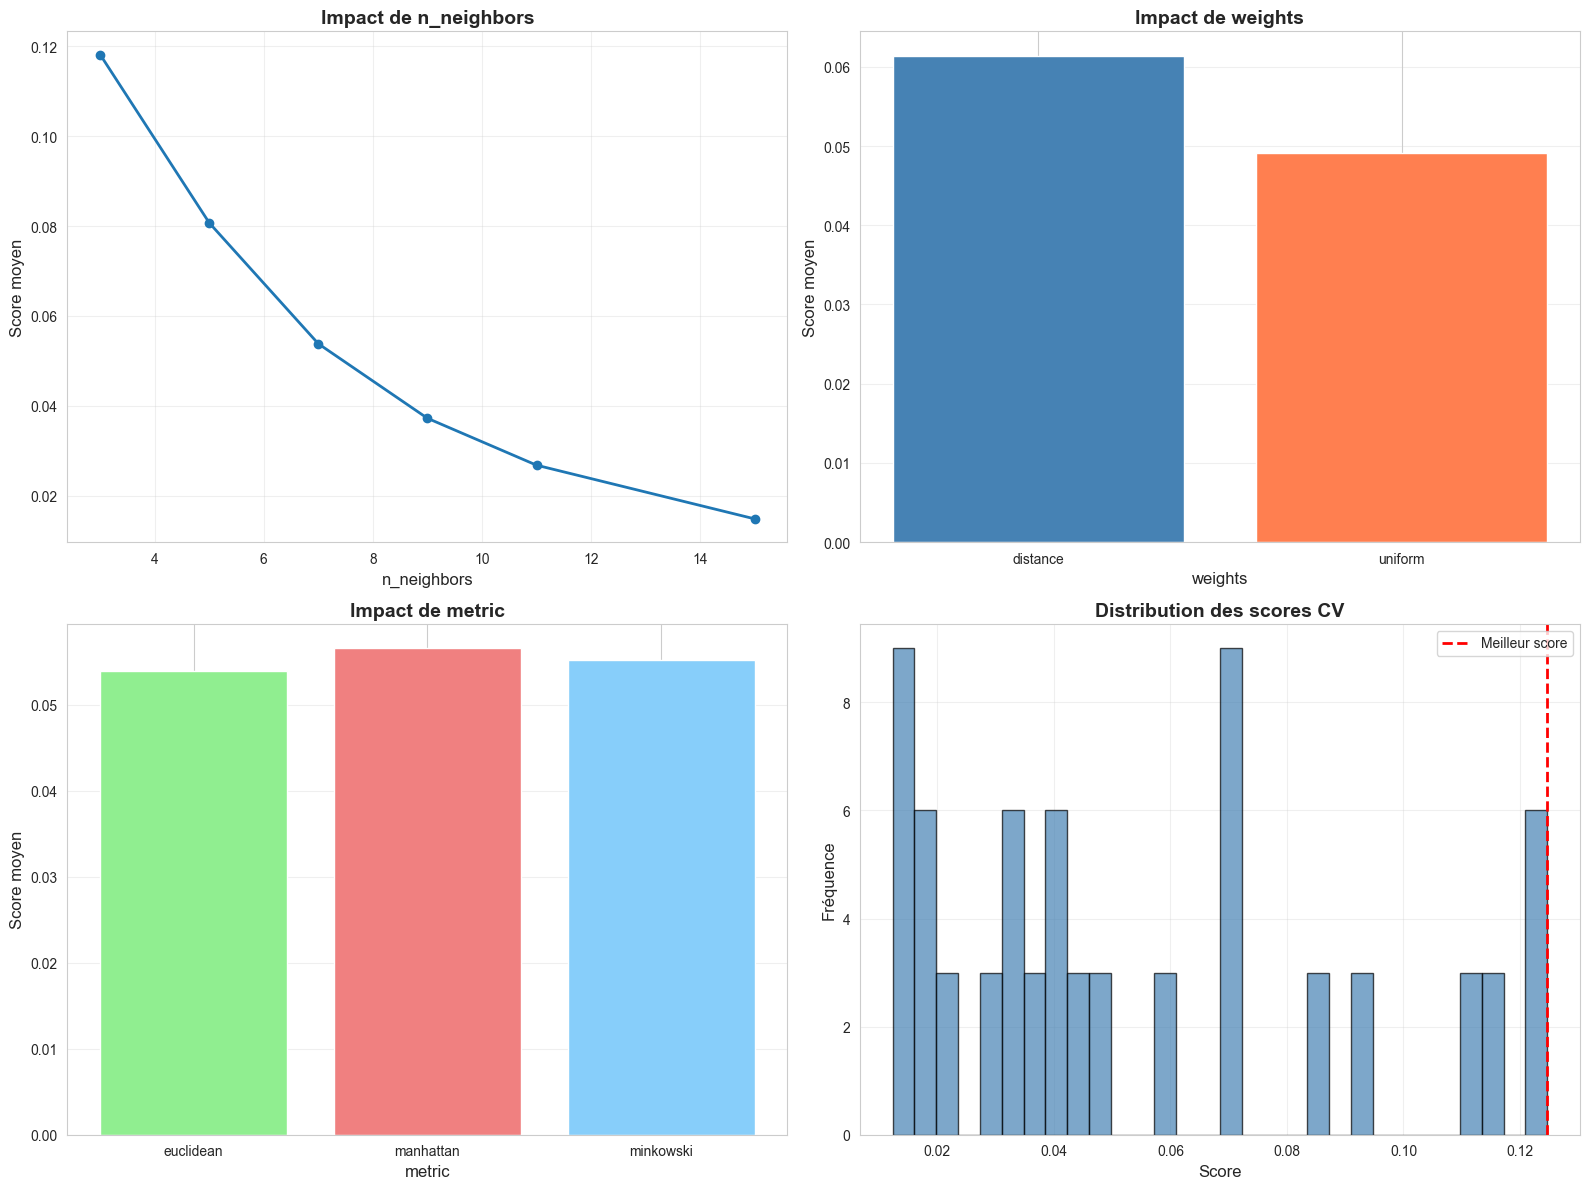


SAUVEGARDE DES RÉSULTATS
✓ Modèle sauvegardé : ../models\knn_optimized.pkl
✓ Résultats sauvegardés : ../results\knn_optimized_results.json
✓ Résultats CV sauvegardés : ../results\knn_optimized_cv_results.csv

Tous les fichiers ont été sauvegardés.


In [21]:

# ============================================================================
# UTILISATION
# ============================================================================
if __name__ == "__main__":
    
    # Supposons que vous avez déjà vos données préparées
    # X_train, y_train, X_test, y_test
    
    # Optimisation
    best_model, results = optimize_knn(
        X_train_clean, 
        y_train, 
        X_test_clean, 
        y_test,
        scoring='f1'  # ou 'roc_auc', 'recall', etc.
    )
    
    # Visualisation
    plot_optimization_results(results)
    
    # Sauvegarde
    save_optimization_results(results, prefix="knn_optimized")

In [ ]:
# ============================================================================
# SOLUTION DE CONTOURNEMENT : TESTER TOUTES LES COMBINAISONS POSSIBLES
# ============================================================================

# Chargement du modèle
model = joblib.load("../models/rank1_KNN_dropna.pkl")
print(f"Modèle attend : {model.n_features_in_} features")

# Chargement des données
df = pd.read_csv("../data/df_dropna_normalized.csv")
X = df.drop(columns=['embauche'])
y = df['embauche']

print(f"Données actuelles : {X.shape[1]} features")

# ============================================================================
# MÉTHODE 1 : IDENTIFIER LES 32 FEATURES PAR ÉLIMINATION LOGIQUE
# ============================================================================
print("\n" + "="*80)
print("IDENTIFICATION DES FEATURES UTILISÉES")
print("="*80)

# Les 6 features en trop sont probablement les features cycliques
# car elles viennent souvent après et peuvent être optionnelles
features_potentiellement_inutiles = [
    'mois_sin', 'mois_cos',           # Features cycliques mois
    'jour_semaine_sin', 'jour_semaine_cos',  # Features cycliques jour
    'semaine_annee_sin', 'semaine_annee_cos'  # Features cycliques semaine
]

# Essayer en supprimant ces 6 features
X_reduced = X.drop(columns=features_potentiellement_inutiles)
print(f"\nAprès suppression des features cycliques : {X_reduced.shape[1]} features")

if X_reduced.shape[1] == 32:
    print("✓ Correspondance trouvée ! Les features cycliques n'étaient pas utilisées.")
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Test rapide de prédiction
    try:
        y_pred = model.predict(X_test[:5])
        print("✓ Le modèle fonctionne avec ces features !")
        X_final = X_test
        feature_names_final = X_reduced.columns.tolist()
    except Exception as e:
        print(f"✗ Erreur : {e}")
        X_final = None

else:
    print("✗ Pas de correspondance, essayons une autre approche...")
    X_final = None

Modèle attend : 32 features
Données actuelles : 38 features

IDENTIFICATION DES FEATURES UTILISÉES

Après suppression des features cycliques : 32 features
✓ Correspondance trouvée ! Les features cycliques n'étaient pas utilisées.
✓ Le modèle fonctionne avec ces features !


In [28]:
# ============================================================================
# CALCUL DE L'IMPORTANCE DES FEATURES (SUITE DE LA MÉTHODE 1)
# ============================================================================

# Chargement du modèle
model = joblib.load("../models/rank1_KNN_dropna.pkl")
print(f"✓ Modèle chargé : {model.n_features_in_} features attendues")

# Chargement des données
df = pd.read_csv("../data/df_dropna_normalized.csv")
X = df.drop(columns=['embauche'])
y = df['embauche']

# Suppression des features cycliques (les 6 en trop)
features_cycliques = ['mois_sin', 'mois_cos', 'jour_semaine_sin', 
                      'jour_semaine_cos', 'semaine_annee_sin', 'semaine_annee_cos']
X_reduced = X.drop(columns=features_cycliques)

print(f"Features après suppression : {X_reduced.shape[1]}")
print(f"Features utilisées : {X_reduced.columns.tolist()}")

# Split train/test (même random_state qu'à l'entraînement)
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nX_test shape : {X_test.shape}")
print(f"y_test shape : {y_test.shape}")

# ============================================================================
# CALCUL DE LA PERMUTATION IMPORTANCE
# ============================================================================
print("\n" + "="*80)
print("CALCUL DE L'IMPORTANCE DES FEATURES")
print("="*80)
print("Méthode : Permutation Importance")
print("Répétitions : 10")
print("Métrique : F1-Score")
print("\nCalcul en cours (cela peut prendre quelques minutes)...\n")

perm_importance = permutation_importance(
    model, 
    X_test, 
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='f1',
    n_jobs=-1
)

print("\n✓ Calcul terminé")


✓ Modèle chargé : 32 features attendues
Features après suppression : 32
Features utilisées : ['age', 'exp', 'salaire', 'note', 'annee', 'trimestre', 'exp_age_ratio', 'salaire_par_exp', 'ecart_exp_max', 'diplome_x_exp', 'diplome_x_note', 'exp_x_note', 'score_composite', 'exp_elevee_pour_age', 'salaire_eleve', 'note_elevee', 'diplome_eleve', 'est_senior', 'profil_atypique', 'diplome_encoded', 'niveau_experience_encoded', 'categorie_age_encoded', 'tranche_salaire_encoded', 'niveau_note_encoded', 'sexe_encoded', 'dispo_encoded', 'cheveux_brun', 'cheveux_chatain', 'cheveux_roux', 'spec_detective', 'spec_forage', 'spec_geologie']

X_test shape : (3805, 32)
y_test shape : (3805,)

CALCUL DE L'IMPORTANCE DES FEATURES
Méthode : Permutation Importance
Répétitions : 10
Métrique : F1-Score

Calcul en cours (cela peut prendre quelques minutes)...


✓ Calcul terminé


In [29]:

# ============================================================================
# CRÉATION DU DATAFRAME
# ============================================================================
importance_df = pd.DataFrame({
    'Feature': X_test.columns.tolist(),
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False).reset_index(drop=True)

importance_df['Rank'] = importance_df.index + 1


In [30]:

# ============================================================================
# AFFICHAGE
# ============================================================================
print("\n" + "="*80)
print("TOP 15 FEATURES LES PLUS IMPORTANTES")
print("="*80)
print()

for idx, row in importance_df.head(15).iterrows():
    print(f"{row['Rank']:2d}. {row['Feature']:35s} | "
          f"Importance: {row['Importance']:7.4f} (±{row['Std']:.4f})")

print("\n" + "="*80)
print("STATISTIQUES")
print("="*80)
print(f"Total features : {len(importance_df)}")
print(f"Importance moyenne : {importance_df['Importance'].mean():.4f}")
print(f"Importance médiane : {importance_df['Importance'].median():.4f}")
print(f"Importance cumulée (Top 5) : {importance_df.head(5)['Importance'].sum():.4f}")
print(f"Importance cumulée (Top 10) : {importance_df.head(10)['Importance'].sum():.4f}")
print(f"Importance cumulée (Top 15) : {importance_df.head(15)['Importance'].sum():.4f}")



TOP 15 FEATURES LES PLUS IMPORTANTES

 1. salaire_par_exp                     | Importance:  0.7100 (±0.0153)
 2. exp_x_note                          | Importance:  0.7097 (±0.0110)
 3. diplome_x_note                      | Importance:  0.6440 (±0.0130)
 4. note                                | Importance:  0.2958 (±0.0158)
 5. diplome_x_exp                       | Importance:  0.2395 (±0.0158)
 6. ecart_exp_max                       | Importance:  0.2279 (±0.0161)
 7. age                                 | Importance:  0.2206 (±0.0200)
 8. score_composite                     | Importance:  0.1977 (±0.0154)
 9. exp                                 | Importance:  0.0250 (±0.0042)
10. annee                               | Importance:  0.0048 (±0.0027)
11. exp_age_ratio                       | Importance:  0.0038 (±0.0021)
12. trimestre                           | Importance:  0.0017 (±0.0017)
13. spec_detective                      | Importance:  0.0003 (±0.0006)
14. niveau_note_encoded  

In [31]:

# ============================================================================
# INTERPRÉTATION MÉTIER
# ============================================================================
print("\n" + "="*80)
print("INTERPRÉTATION MÉTIER - TOP 5")
print("="*80)

interpretations = {
    'exp': "Expérience professionnelle - facteur déterminant",
    'note': "Performance académique - indicateur de compétence",
    'salaire': "Prétentions salariales - alignement avec le poste",
    'age': "Âge du candidat - maturité et expérience",
    'diplome_encoded': "Niveau de diplôme - qualification de base",
    'salaire_par_exp': "Ratio salaire/expérience - cohérence du profil",
    'exp_age_ratio': "Ratio expérience/âge - précocité professionnelle",
    'score_composite': "Score global - vue d'ensemble du profil",
    'diplome_x_exp': "Interaction diplôme-expérience - synergie",
    'niveau_experience_encoded': "Catégorie d'expérience - niveau de séniorité"
}

for idx, row in importance_df.head(5).iterrows():
    feature = row['Feature']
    importance = row['Importance']
    interpretation = interpretations.get(feature, "Variable importante pour la prédiction")
    print(f"\n{row['Rank']}. {feature}")
    print(f"   Importance: {importance:.4f}")
    print(f"   → {interpretation}")



INTERPRÉTATION MÉTIER - TOP 5

1. salaire_par_exp
   Importance: 0.7100
   → Ratio salaire/expérience - cohérence du profil

2. exp_x_note
   Importance: 0.7097
   → Variable importante pour la prédiction

3. diplome_x_note
   Importance: 0.6440
   → Variable importante pour la prédiction

4. note
   Importance: 0.2958
   → Performance académique - indicateur de compétence

5. diplome_x_exp
   Importance: 0.2395
   → Interaction diplôme-expérience - synergie


In [32]:

# ============================================================================
# SAUVEGARDE
# ============================================================================
import os

results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)

# CSV
csv_path = os.path.join(results_dir, "knn_feature_importance.csv")
importance_df.to_csv(csv_path, index=False)
print(f"\n✓ CSV sauvegardé : {csv_path}")

# TXT formaté
txt_path = os.path.join(results_dir, "knn_feature_importance.txt")
with open(txt_path, 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("IMPORTANCE DES FEATURES - MODÈLE KNN FINAL\n")
    f.write("="*80 + "\n\n")
    
    f.write("MÉTHODE : Permutation Importance (10 répétitions)\n")
    f.write("MÉTRIQUE : F1-Score\n")
    f.write("MODÈLE : KNeighborsClassifier (n_neighbors=5, weights='distance')\n\n")
    
    f.write("="*80 + "\n")
    f.write("TOUTES LES FEATURES (Triées par importance)\n")
    f.write("="*80 + "\n\n")
    
    for idx, row in importance_df.iterrows():
        f.write(f"{row['Rank']:2d}. {row['Feature']:35s} | "
               f"Importance: {row['Importance']:7.4f} (±{row['Std']:.4f})\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write("STATISTIQUES GLOBALES\n")
    f.write("="*80 + "\n")
    f.write(f"Total features : {len(importance_df)}\n")
    f.write(f"Importance moyenne : {importance_df['Importance'].mean():.4f}\n")
    f.write(f"Importance médiane : {importance_df['Importance'].median():.4f}\n")
    f.write(f"Importance cumulée (Top 5) : {importance_df.head(5)['Importance'].sum():.4f}\n")
    f.write(f"Importance cumulée (Top 10) : {importance_df.head(10)['Importance'].sum():.4f}\n")
    f.write(f"Importance cumulée (Top 15) : {importance_df.head(15)['Importance'].sum():.4f}\n")
    f.write(f"Importance totale : {importance_df['Importance'].sum():.4f}\n")

print(f"✓ Rapport texte sauvegardé : {txt_path}")



✓ CSV sauvegardé : ../results\knn_feature_importance.csv
✓ Rapport texte sauvegardé : ../results\knn_feature_importance.txt


✓ Graphique Top 15 sauvegardé : ../results/plots/knn_feature_importance_top15.png


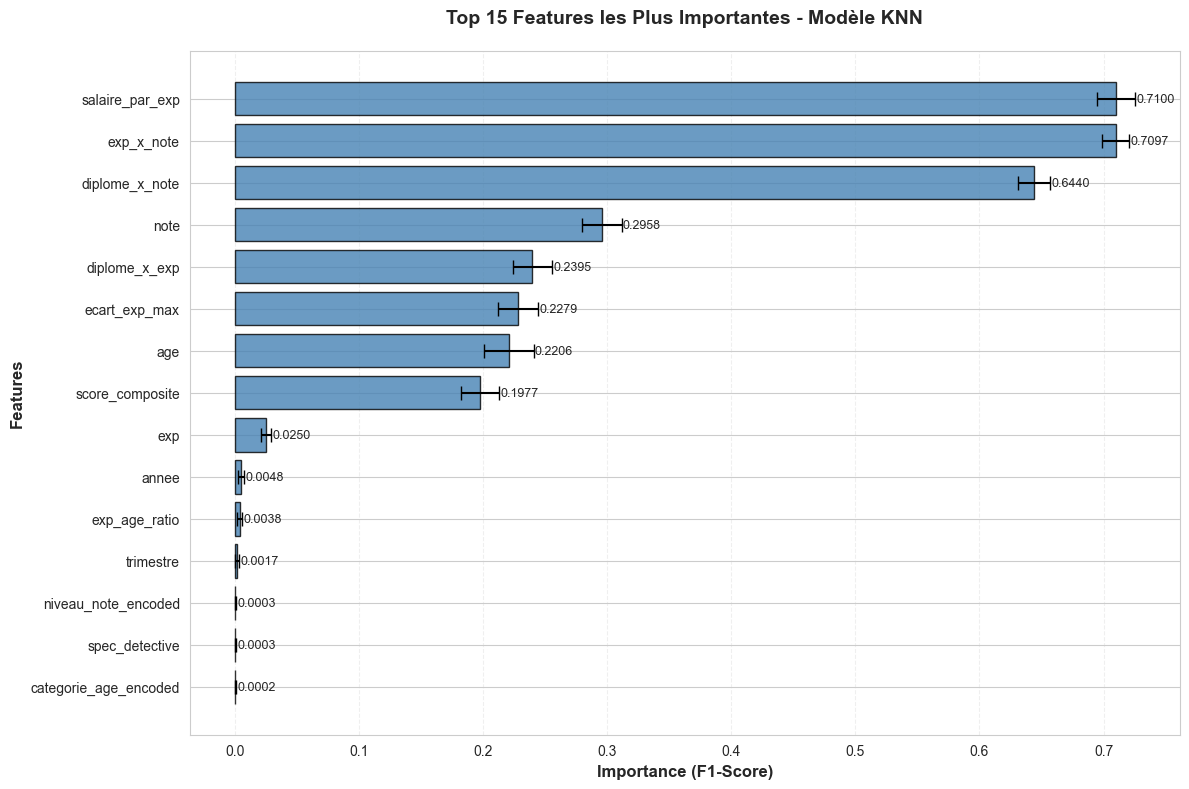

✓ Graphique complet sauvegardé : ../results/plots/knn_feature_importance_all.png


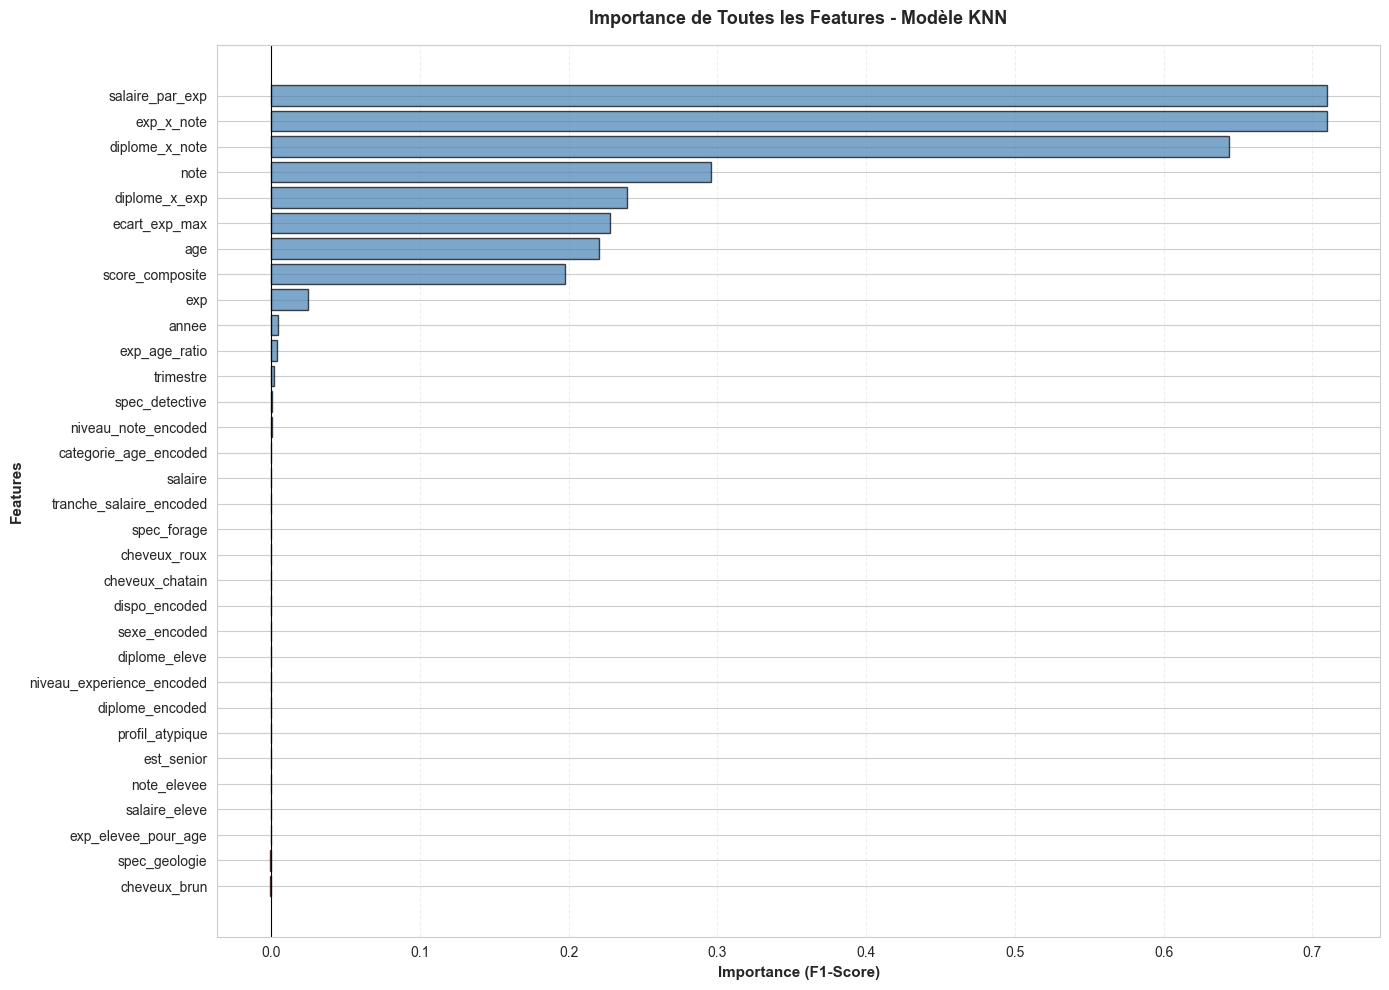

✓ Graphique cumulatif sauvegardé : ../results/plots/knn_feature_importance_cumulative.png


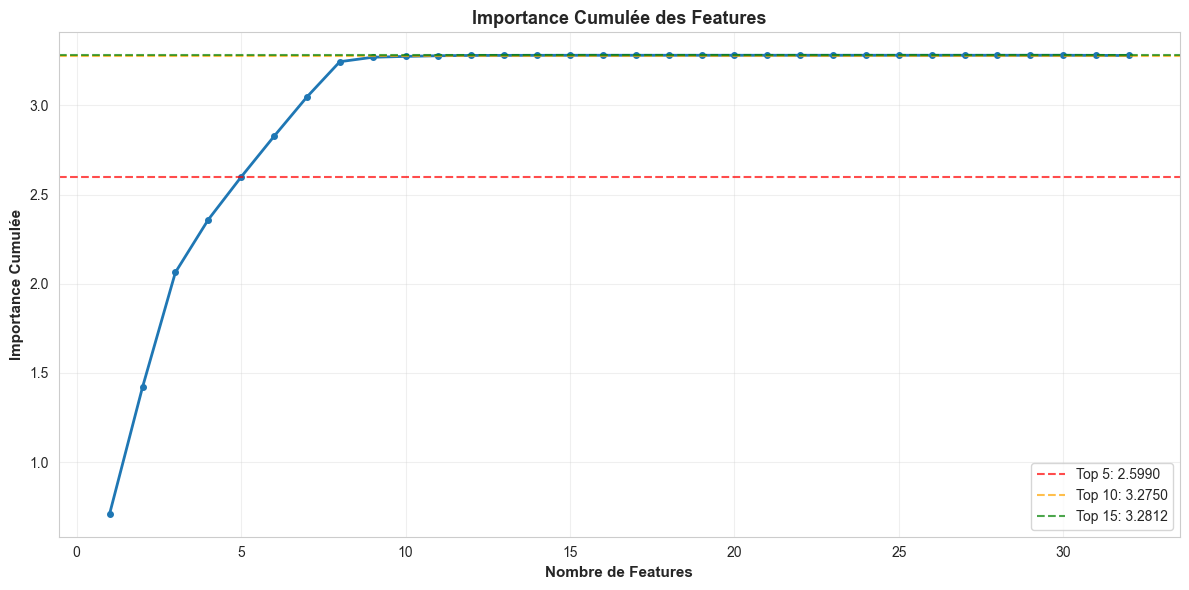


ANALYSE TERMINÉE

Fichiers générés:
  - ../results\knn_feature_importance.csv
  - ../results\knn_feature_importance.txt
  - ../results/plots/knn_feature_importance_top15.png
  - ../results/plots/knn_feature_importance_all.png
  - ../results/plots/knn_feature_importance_cumulative.png


In [33]:

# ============================================================================
# VISUALISATIONS
# ============================================================================
os.makedirs("../results/plots", exist_ok=True)

# Graphique 1 : Top 15 avec barres d'erreur
fig, ax = plt.subplots(figsize=(12, 8))

df_plot = importance_df.head(15).sort_values('Importance', ascending=True)

ax.barh(df_plot['Feature'], df_plot['Importance'], 
        xerr=df_plot['Std'], color='steelblue', 
        edgecolor='black', alpha=0.8, capsize=5)

ax.set_xlabel('Importance (F1-Score)', fontsize=12, fontweight='bold')
ax.set_ylabel('Features', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Features les Plus Importantes - Modèle KNN', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Annotations
for i, (idx, row) in enumerate(df_plot.iterrows()):
    ax.text(row['Importance'] + row['Std'] + 0.001, i, 
            f"{row['Importance']:.4f}", va='center', fontsize=9)

plt.tight_layout()
plot_path = "../results/plots/knn_feature_importance_top15.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Graphique Top 15 sauvegardé : {plot_path}")
plt.show()

# Graphique 2 : Toutes les features (compact)
fig, ax = plt.subplots(figsize=(14, 10))

df_all = importance_df.sort_values('Importance', ascending=True)

colors = ['red' if x < 0 else 'steelblue' for x in df_all['Importance']]
ax.barh(df_all['Feature'], df_all['Importance'], color=colors, alpha=0.7, edgecolor='black')

ax.set_xlabel('Importance (F1-Score)', fontsize=11, fontweight='bold')
ax.set_ylabel('Features', fontsize=11, fontweight='bold')
ax.set_title('Importance de Toutes les Features - Modèle KNN', 
             fontsize=13, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.axvline(0, color='black', linewidth=0.8)

plt.tight_layout()
plot_path_all = "../results/plots/knn_feature_importance_all.png"
plt.savefig(plot_path_all, dpi=300, bbox_inches='tight')
print(f"✓ Graphique complet sauvegardé : {plot_path_all}")
plt.show()

# Graphique 3 : Importance cumulée
fig, ax = plt.subplots(figsize=(12, 6))

cumsum = importance_df['Importance'].cumsum()
ax.plot(range(1, len(cumsum)+1), cumsum, marker='o', linewidth=2, markersize=4)
ax.axhline(cumsum.iloc[4], color='red', linestyle='--', alpha=0.7, 
           label=f'Top 5: {cumsum.iloc[4]:.4f}')
ax.axhline(cumsum.iloc[9], color='orange', linestyle='--', alpha=0.7, 
           label=f'Top 10: {cumsum.iloc[9]:.4f}')
ax.axhline(cumsum.iloc[14], color='green', linestyle='--', alpha=0.7, 
           label=f'Top 15: {cumsum.iloc[14]:.4f}')

ax.set_xlabel('Nombre de Features', fontsize=11, fontweight='bold')
ax.set_ylabel('Importance Cumulée', fontsize=11, fontweight='bold')
ax.set_title('Importance Cumulée des Features', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plot_path_cumsum = "../results/plots/knn_feature_importance_cumulative.png"
plt.savefig(plot_path_cumsum, dpi=300, bbox_inches='tight')
print(f"✓ Graphique cumulatif sauvegardé : {plot_path_cumsum}")
plt.show()

print("\n" + "="*80)
print("ANALYSE TERMINÉE")
print("="*80)
print("\nFichiers générés:")
print(f"  - {csv_path}")
print(f"  - {txt_path}")
print(f"  - {plot_path}")
print(f"  - {plot_path_all}")
print(f"  - {plot_path_cumsum}")
print("="*80)